In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [0]:
class basic_model(tf.keras.Model):
  def __init__(self):
    super(basic_model, self).__init__()
    self.conv_layer_1 = tf.keras.layers.Conv2D(128, 5, 1, padding='same', activation='relu')
    self.max_pool_1 = tf.keras.layers.MaxPool2D()
    self.conv_layer_2 = tf.keras.layers.Conv2D(128, 5, 1, padding='same', activation='relu')
    self.max_pool_2 = tf.keras.layers.MaxPool2D()
    self.conv_layer_3 = tf.keras.layers.Conv2D(128, 5, 1, padding='same', activation='relu')
    self.max_pool_3 = tf.keras.layers.MaxPool2D()
    self.flat = tf.keras.layers.Flatten()
    self.output_layer = tf.keras.layers.Dense(10, activation='softmax')

  def call(self, inputs):
    x = self.conv_layer_1(inputs)
    x = self.max_pool_1(x)
    x = self.conv_layer_2(x)
    x = self.max_pool_2(x)
    x = self.conv_layer_3(x)
    x = self.max_pool_3(x)
    x = self.flat(x)
    x = self.output_layer(x)
    return x

In [0]:
base_model = basic_model()
# model.build(input_shape=(None,28,28,1))

In [0]:
# input_layer = tf.keras.layers.Input(shape=(30,30,1))
# x = base_model(input_layer)

# model = tf.keras.models.Model(input_layer, x)

In [0]:
base_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# 1) MNIST

In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [8]:
x_train.shape

(60000, 28, 28)

In [9]:
test_batch_size = 32

print(len(x_train) // 32)

1875


In [0]:
class MNIST_Generator(tf.keras.utils.Sequence):
  def __init__(self, x_data, y_data, batch_size, target_size, shuffle=True, augmentation=False):
    self.x_data = x_data
    self.y_data = y_data
    self.batch_size = batch_size
    self.target_size = target_size
    self.shuffle = shuffle
    self.augmentation = augmentation
    self.on_epoch_end()

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.x_data))
    if self.shuffle:
      indexes = np.random.shuffle(self.indexes)

  def __len__(self):
    return int(np.ceil(len(self.x_data) / self.batch_size))

  def __getitem__(self, index):
    batch_indexes = self.indexes[index * self.batch_size : (index+1) * self.batch_size]
 
    x, y = self.__preprocess_data(self.x_data, self.y_data)
    x = self.__resize_data(x, self.target_size)
  
    return x[batch_indexes], y[batch_indexes]

  def __resize_data(self, x_data, target_size):
    x = np.asarray([cv2.resize(img, dsize=target_size) for img in x_data])
    if len(x.shape) == 3:
      x = np.expand_dims(x, axis=3)
    # print(x.shape)
    return x
  
  def __preprocess_data(self, x_data, y_data):
    x = np.expand_dims(x_data, axis=3)
    # print(x.shape)
    x = (x - 127.5) / 127.5
    x = x.astype(np.float32)
    y = tf.keras.utils.to_categorical(y_data, num_classes=10)
    return x, y

In [0]:
generator = MNIST_Generator(x_train, y_train, 512, (30,30), True, True)

In [17]:
generator.indexes

array([26189, 43978, 41777, ..., 39106, 31102, 47131])

In [18]:
generator.__len__()

118

In [0]:
x, y = next(iter(generator))

In [20]:
x.shape

(512, 30, 30, 1)

In [21]:
y.shape

(512, 10)

In [0]:
train_generator = MNIST_Generator(x_train, y_train, 512, (35,35), True, True)
valid_generator = MNIST_Generator(x_test, y_test, 512, (35,35), False, True)

In [29]:
hist = base_model.fit_generator(train_generator,
                                epochs=10,
                                validation_data = valid_generator)

  ...
    to  
  ['...']
Train for 118 steps, validate for 20 steps
Epoch 1/10
118/118 [==============================] - 100s 848ms/step - loss: 0.2433 - acc: 0.9265 - val_loss: 0.0541 - val_acc: 0.9843
Epoch 2/10
118/118 [==============================] - 98s 831ms/step - loss: 0.0447 - acc: 0.9862 - val_loss: 0.0285 - val_acc: 0.9913
Epoch 3/10
118/118 [==============================] - 98s 831ms/step - loss: 0.0280 - acc: 0.9916 - val_loss: 0.0375 - val_acc: 0.9880
Epoch 4/10
118/118 [==============================] - 99s 839ms/step - loss: 0.0218 - acc: 0.9931 - val_loss: 0.0303 - val_acc: 0.9900
Epoch 5/10
118/118 [==============================] - 99s 837ms/step - loss: 0.0173 - acc: 0.9945 - val_loss: 0.0272 - val_acc: 0.9919
Epoch 6/10
118/118 [==============================] - 97s 824ms/step - loss: 0.0121 - acc: 0.9962 - val_loss: 0.0205 - val_acc: 0.9935
Epoch 7/10
118/118 [==============================] - 95s 806ms/step - loss: 0.0095 - acc: 0.9968 - val_loss: 0.0220 - va

In [30]:
x_train_n = (x_train - 127.5) / 127.5
x_train_n = np.expand_dims(x_train_n, 3)

x_test_n = (x_test - 127.5) / 127.5
x_test_n = np.expand_dims(x_test_n, axis=3)

y_train_n = tf.keras.utils.to_categorical(y_train)
y_test_n = tf.keras.utils.to_categorical(y_test)
print(x_train_n.shape)
print(y_train_n.shape)

model_test = basic_model()
model_test.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

hist = model_test.fit(x_train_n, y_train_n, epochs=10, batch_size=512, validation_data=(x_test_n, y_test_n))

(60000, 28, 28, 1)
(60000, 10)
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 133us/sample - loss: 0.3101 - acc: 0.9078 - val_loss: 0.0692 - val_acc: 0.9770
Epoch 2/10
60000/60000 [==============================] - 6s 108us/sample - loss: 0.0486 - acc: 0.9851 - val_loss: 0.0342 - val_acc: 0.9897
Epoch 3/10
60000/60000 [==============================] - 6s 108us/sample - loss: 0.0305 - acc: 0.9906 - val_loss: 0.0270 - val_acc: 0.9918
Epoch 4/10
60000/60000 [==============================] - 7s 109us/sample - loss: 0.0230 - acc: 0.9929 - val_loss: 0.0230 - val_acc: 0.9930
Epoch 5/10
60000/60000 [==============================] - 7s 109us/sample - loss: 0.0178 - acc: 0.9944 - val_loss: 0.0249 - val_acc: 0.9916
Epoch 6/10
60000/60000 [==============================] - 7s 110us/sample - loss: 0.0137 - acc: 0.9958 - val_loss: 0.0212 - val_acc: 0.9931
Epoch 7/10
60000/60000 [==============================] - 7s 110us/sample - los

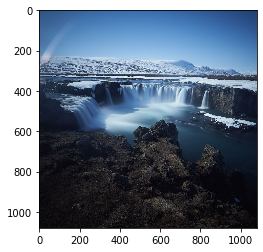

In [56]:
test_img = plt.imread('/content/image_0.png',0)

plt.imshow(test_img)
plt.show()


In [58]:
test_img.shape

(1080, 1080, 3)

In [59]:
cv2.resize(test_img, (255,255)).shape

(255, 255, 3)